# 6. Random forests

In [1]:
%matplotlib inline
import warnings;warnings.filterwarnings('ignore');import matplotlib.pyplot as plt;import numpy as np;import pandas as pd;import seaborn as sns;sns.set_context("notebook", font_scale=1.4);sns.set_style("whitegrid");import imp;compomics_import = imp.load_source('compomics_import', '../compomics_import.py');from IPython.core.display import HTML;css_file = '../my.css';HTML(open(css_file, "r").read())

Another popular method for solving both classification and regression tasks in bioinformatics is the **random forest** algorithm. It is shown to compute very accurate prediction models for various types of data sets and typically outperforms other models on data sets with heterogeneous features, features that represent very different types of information such as the age of patient and the expression measurement of a certain gene in that patient. Finding dependencies between these types of features is easy for a random forest as it employs decision trees to construct the decision boundary where each tree tests each feature individually. To explain this we need to first explain the decision tree model.  

A **decision tree** is a flowchart-like structure in which each **internal node** represents a test on a feature, each **branch** represents a possible outcome of the test and each **leaf node** represents a target. The paths from root to leaf represent prediction rules. Decision trees can be used to solve both classification and regression tasks, but here we will restrict the description to classification trees. Here is an example of a decision tree:

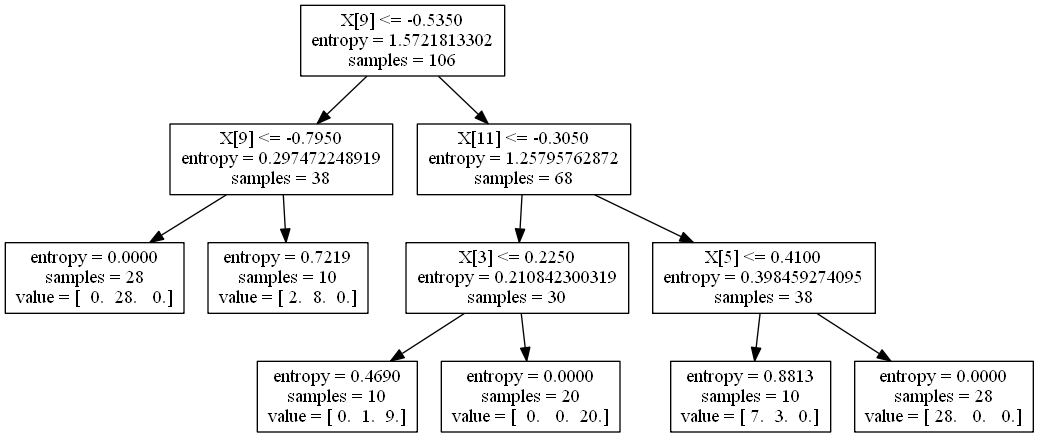

In [2]:
from IPython.core.display import Image
Image("decisiontree.png")

The first test is performed in the **root node** (top node) and checks if feature "X[9]" has a value smaller than or equal to -0.5350. If it is then we follow the left branch in the flowchart, if it isn't we follow the right branch. This process is repeated until we reach a leaf node from which we obtain predicted class probabilities. 

The decision tree is built in a **top-down** fashion where the main question is how to choose which feature to split at each node? The answer is to find the feature that best splits the target class into the purest possible children nodes. This **measure of purity** is typically computed as the oposite of the entropy (which is a measure of impurity) of the class label probabilities in the data set. 

The idea behind classification decision tree construction is to assign an **entropy value to a set of data label probabilities** and use this entropy to find the **best split** at each node in the decision tree. Suppose we have a data set with 100 samples of which 20 belong to class 1 and 80 belong to class 2. For this data set the probability $p_1$ that a data point belongs to class 1 is 0.2, the probability $p_2$ that a data point belongs to class 2 is 0.8. 

The entropy $H$ of these two class label probabilities $p$ is computed as

$$H(p) = -p_1 log_2(p_1) -p_2 log_2(p_2).$$ 

More general the entropy of any number of probabilities is computed as

$$H(p) = -\sum_i p_i log_2(p_i),$$

where $i$ ranges over the class probabilities. Let's compute the entropy for the probability of the classes in our data set:

In [3]:
from scipy.stats import entropy

entropy([.2,.8],base=2)

0.72192809488736231

Now suppose our data set contains only one sample for class 1 and 99 for class 2:

In [4]:
entropy([.01,.99],base=2)

0.080793135895911181

The entropy for this data set is much lower. To maximize the entropy of a data set we have to create one with an equal number of samples for class 1 and 2:

In [5]:
entropy([.5,.5],base=2)

1.0

In this case the uncertainty about the classes is maximal. The **binary entropy function** for two classes looks like this:

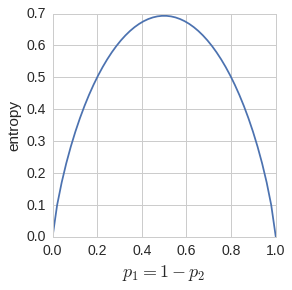

In [6]:
plt.figure(figsize=(4,4))
compomics_import.plot_entropy_function()
plt.show()

A decision tree is constructed by **recursively splitting** (partitioning) a data set $D$. For each split the learning algorithm finds the feature that *best* partitioned the data set. To find this feature we can use several criteria, one of them is called **information gain**.

Information gain is the difference between the current entropy of a system and the entropy measured after a feature is chosen. If $D$ is a set of samples and $x$ is a possible feature that partitions $D$ in subsets $D_v$, then:

$$G(D,x) = \text{Entropy}(D) - \sum\frac{|D_v|}{|D|} \text{Entropy}(D_v).$$

The **decision tree learning algorithm** computes the information gain for each feature and selects the one with the highest value. In this way, it searches the "tree space" according to a greedy strategy, i.e. not all possible trees are evaluated.

A tree is constructed by recursively selecting the feature from the current data set with the largest information gain and adding a test to the decision tree. Refer to "Informatica II" for the details on how to construct a decision tree using the information gain criterion.

Decision trees can become very complex which makes them prone to overfitting the train set. To prevent this, the decision tree learning algorithm stops growing the tree if the information gain is not sufficient to justify the extra complexity of adding another node. Other **stopping criteria** exist such as limiting the number of samples in a node or the depth of the tree.

Let's load a data set that contains information about translation initiation sites (TIS) in genes. The data set contains 13375 feature vectors that each represent a nucleotide sequence of length 203. The middle three nucleotides in these sequences are always ATG and are labeled '1' (positive class) if it forms the start of a translation of a gene and '0' (negative class) otherwise. For each ATG site, 3 nucleotides are matched to 1 amino acid and the count of each amino and di-amino acid is used as a feature. These features are computed for both the upstream- and the downstream region relative to the middle annotated ATG.

In [7]:
dataset = pd.read_csv("TIS.csv", sep=',')
dataset.head()

,UP_A,DOWN_A,UP_R,DOWN_R,UP_N,DOWN_N,UP_D,DOWN_D,UP_C,DOWN_C,...,DOWN_VS,UP_VT,DOWN_VT,UP_VW,DOWN_VW,UP_VY,DOWN_VY,UP_VV,DOWN_VV,label
0,2,2,4,2,0,2,0,4,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,3,2,0,2,2,1,3,0,...,0,0,1,0,0,0,0,0,0,1
2,6,2,5,1,0,2,0,2,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,6,1,1,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
4,2,3,3,2,0,1,1,2,2,0,...,0,0,0,0,1,0,0,0,0,1


There are 881 features:

In [8]:
dataset.shape

(13375, 881)

About 25% of the data points are labeled as positive:

In [9]:
dataset['label'].value_counts() / dataset['label'].count()

0    0.752374
1    0.247626
Name: label, dtype: float64

In scikit-learn there is the `DecisionTreeClassifier` module that computes a decision tree. Here we optimize the maximum tree depth for the decision using `GridSearchCV` and estimate the generalization performance using nested cross-validation:

In [10]:
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X = dataset.copy()
y = X.pop('label').astype('int')

np.random.seed(1)

search_space = {'max_depth':[10,20,30,40]}
model = DecisionTreeClassifier(criterion='entropy')
grid_search = GridSearchCV(model, param_grid=search_space, cv=3)

scores = cross_validation.cross_val_score(grid_search, X, y)
print scores
print "mean CV score = %f" % np.mean(scores)

[ 0.84144427  0.84791386  0.84993271]
mean CV score = 0.846430


Decision trees have several advantages: 

* ease of interpretation
* handles continuous and discrete features
* invariant to monotone transformation of features
* variable selection automated
* robust
* scalable

However, relative to other learning algorithms, decision trees do not predict very accurately, due to the greedy nature of the tree construction algorithm. Also, trees tend to be **unstable**, as small changes to the inputs can have large effects on the structure of the tree; poor decisions near the root of the tree will propagate to the rest of the tree. 
Decision trees therefor are called **high variance** models.

One way to reduce the variance of a model is to average together many models for which to predictions are not highly correlated. In the case of decision trees, we can train $T$ different trees on random subsets of the data and then average the prediction of each model according to:

$$\hat{f}(x,\theta) = \frac{1}{T} \sum_{i=1}^T f_t(x,\theta)$$

where $f_t$ is the $t^{th}$ tree. This approach is called "bootstrap aggregating" ( or **bagging**) and can be applied to many learning algorithms that show high variance. Random forest model are essentially bootstrap aggregated decision trees, where the bagging takes place at the level of the samples and the features. The learning algorithm for fitting a random forest model works as follows:

Construct $t$ decision trees by following these steps:

1. Sample $n$ data points at random - but with replacement, from the training dataset (containing $n$ feature vectors). These will be the training feature vectors for growing the tree. 

2. If there are $m$ features, a number $h<<m$ is specified such that at each node, $h$ variables are selected at random out of the m features and the best split on these $h$ is used to split the node. The value of $h$ is held constant during the forest growing.
 
3. Each tree is grown to the largest extent possible. There is no pruning or early stopping. 

A prediction $y$ is made by majority voting. The proportion of votes for each class $c$ can also be used as the probability of the test point to belong to class $c$. Here estimate the generalization performance of a random forest model (`RandomForestClassifier` from scikit-learn):

In [11]:
from sklearn.ensemble import RandomForestClassifier

search_space = {'n_estimators':[10,50,100], 'max_features':[10,20,40], 'max_depth':[10,50,100]}
model = RandomForestClassifier(random_state=1,n_jobs=-1)
grid_search = GridSearchCV(model, param_grid=search_space, cv=3)

scores = cross_validation.cross_val_score(grid_search, X, y)
print scores
print "mean CV score = %f" % np.mean(scores)

[ 0.87015026  0.87572903  0.8795424 ]
mean CV score = 0.875141


In [12]:
grid_model = grid_search.fit(X,y)

In [13]:
print grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=40, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


Notice how the random forest algorithm computes more accurate TIS classification models. 


For the construction of each tree in the forest we used only part of the data set, this will typically be 1/3 of the train data, which means that we can use the remaining 1/3 of the train data (that is not seen during training) as test points for this tree. As the subsampling is random for each tree, each data point should be used as test point many times. We can thus use the predictions for these test points to evaluate the performance of the random forest model. The obtained metric is called the **out-of-bag performance** (oob). In scikit-learn we can obtain the oob as follows:

In [14]:
model = RandomForestClassifier(n_estimators=100,max_features=40,max_depth=50,oob_score=True,random_state=1)
model.fit(X,y)
print model.oob_score_

0.871626168224


<strong>Exercises</strong>

- Load the Breast Cancer Wisconsin data set. Use `GridSearchCV` to optimize a random forest model.

- Compare these results to the SVM model with Gaussian kernel function on the same data set.